<a href="https://colab.research.google.com/github/swanand11/AirTraffic_Forecasting_ARIMA/blob/complete_analysis/Air_Traffic_control_using_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Traffic control using ARIMA Model.
---
Objectives:

* Line plot of historical air traffic data.
* Forecast plot showing actual vs predicted values.
* Autocorrelation plot (ACF/PACF).
* Decomposition of time series into trend, seasonality, and residuals.

---
How we decided to proceed with this project:



1. Line plot of historical air traffic data.
2. Decomposition of time series into trends that can be derived from the data like Seasonality, Recurring patterns, Residuals etc.
3. Check for Stationarity: use ADF test to check of data stationarity and report it.
4. Justify the use of ARIMA model for this type of data.
5. Autocorrelation plot(ACF/PACF) : using this to define the parameters of our ARIMA model (p,d,f)
6. Fit ARIMA model : train arima model to learn from historical data. We are using AirPassesngers dataset. Leave the data of last 2 years as test data.
7. Forecast future Air Traffic : probably 24 months.
8. Compare Actual v/s Predicted data of 2 years : Use the predicted data of 2 years(like 1959-1960) and compare it to the actual data we kept as test data from the dataset to check the models accuracy.



### 1. Line Plot of Historical Air Traffic Data
---
This section includes the following parts:

*   Installing and loading all the packages we will need
  
  *   `zoo` : converts the built-in AirPassengers time series to monthly date format (e.g., "Jan 1949") for easier plotting and data frame manipulation.
  *   `dpylr` : For data manipulation and transformation using pipes(%>%).
  *   `tseries` : This is used for time series Statistical analysis.
  *   `forecast` : For fitting ARIMA models, forecasting, and evaluating model accuracy.
    Used in:
     `auto.arima(`) for finding best ARIMA model
     ,`forecast()` for generating future predictions
     ,`accuracy()` for calculating error metrics (RMSE, MAE, etc.)
*   Data Cleaning
*   EDA function :
     It deals with
   1.   Studying the structure of our dataset
   2.   View basic statistics(summary())
   3.   Check for missing data
   4.   Visualize trends over time
   5.   Analyze seasonality using monthly averages





In [ ]:
# Installing and loading all important libraries

install.packages(c('zoo','ggplot2','dplyr','tseries','forecast'))

library(zoo)
library(ggplot2)
library(dplyr)
library(tseries)
library(forecast)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
# Data Cleaning
df <- data.frame(
  Date = as.yearmon(time(AirPassengers)),
  Passengers = as.numeric(AirPassengers)
)
df$Year <- format(df$Date, "%Y")
df$Month <- format(df$Date, "%B")
df$Month <- factor(df$Month, levels = month.name, ordered = TRUE)
df <- df[, c("Month", "Year", "Passengers")]

ts_data <- ts(df$Passengers, start = c(1949, 1), frequency = 12)

 1. Data Structure:
'data.frame':	144 obs. of  3 variables:
 $ Month     : Ord.factor w/ 12 levels "January"<"February"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Year      : chr  "1949" "1949" "1949" "1949" ...
 $ Passengers: num  112 118 132 129 121 135 148 148 136 119 ...
NULL

 2. Summary Statistics:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  104.0   180.0   265.5   280.3   360.5   622.0 

3. Missing Values:
     Month       Year Passengers 
         0          0          0 

 4. Yearly Trend Plot:

 5. Seasonality Check: Monthly Distribution


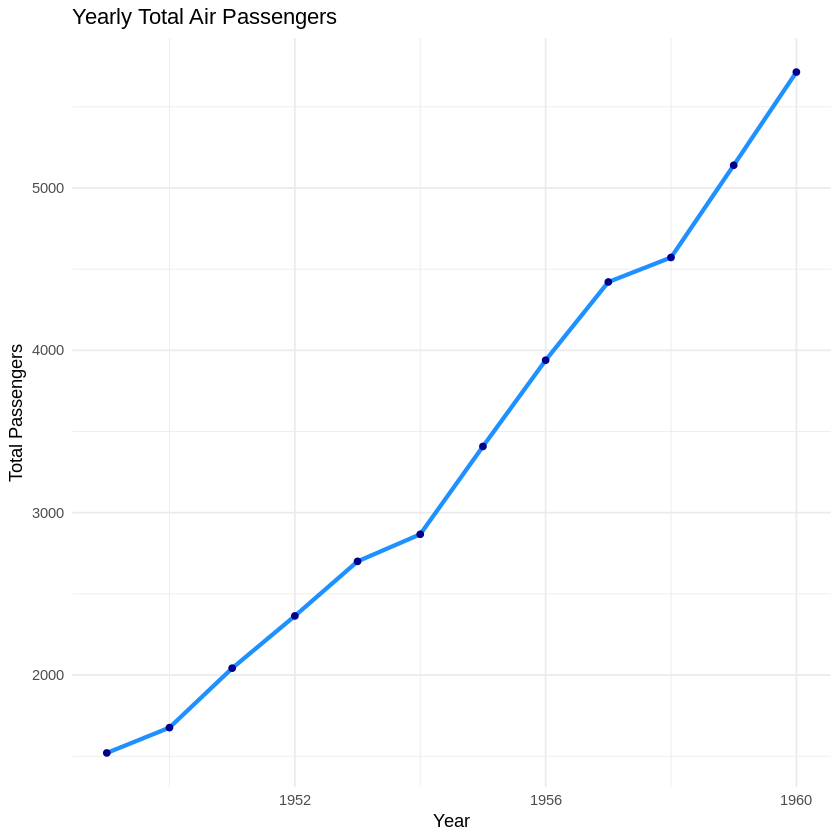


6. Average Passengers by Month:
# A tibble: 12 × 2
   Month     Average_Passengers
   <ord>                  <dbl>
 1 January                 242.
 2 February                235 
 3 March                   270.
 4 April                   267.
 5 May                     272.
 6 June                    312.
 7 July                    351.
 8 August                  351.
 9 September               302.
10 October                 267.
11 November                233.
12 December                262.


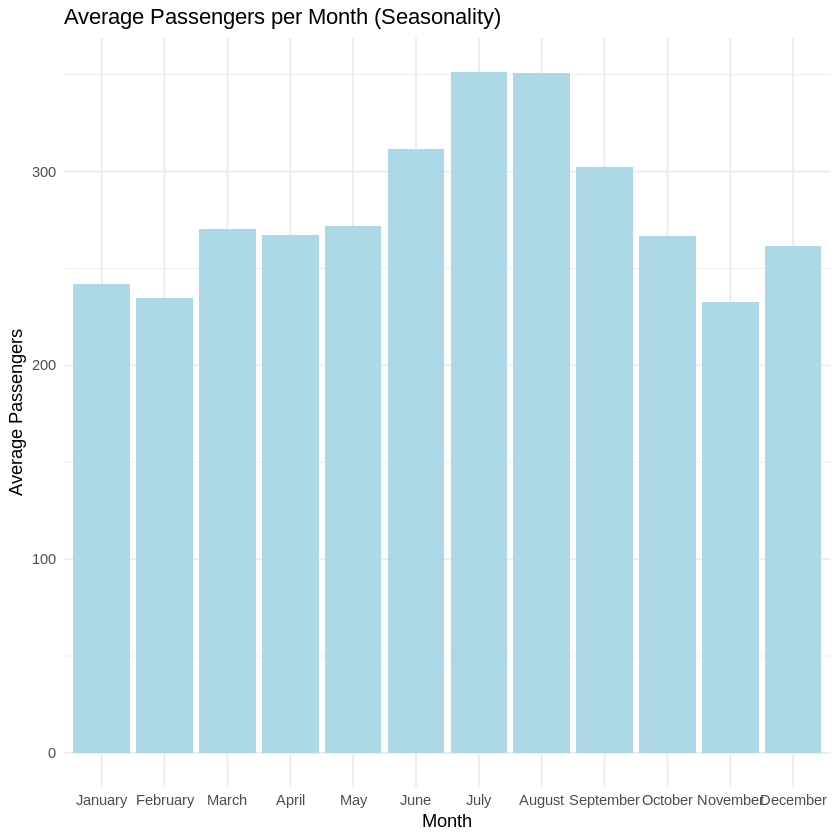

In [ ]:
# EDA Function
eda_air_traffic <- function(data) {
  cat(" 1. Data Structure:\n")
  print(str(data))

  cat("\n 2. Summary Statistics:\n")
  print(summary(data$Passengers))

  cat("\n3. Missing Values:\n")
  print(colSums(is.na(data)))

  cat("\n 4. Yearly Trend Plot:\n")
  yearly_data <- data %>%
    group_by(Year) %>%
    summarise(Total_Passengers = sum(Passengers))

  print(
    ggplot(yearly_data, aes(x = as.numeric(Year), y = Total_Passengers)) +
      geom_line(color = "dodgerblue", linewidth = 1.2) +
      geom_point(color = "darkblue") +
      labs(title = "Yearly Total Air Passengers",
           x = "Year",
           y = "Total Passengers") +
      theme_minimal()
  )

  cat("\n 5. Seasonality Check: Monthly Distribution\n")
  monthly_avg <- data %>%
    group_by(Month) %>%
    summarise(Average_Passengers = mean(Passengers)) %>%
    arrange(match(Month, month.name))

  print(
    ggplot(monthly_avg, aes(x = Month, y = Average_Passengers)) +
      geom_bar(stat = "identity", fill = "lightblue") +
      labs(title = "Average Passengers per Month (Seasonality)",
           x = "Month",
           y = "Average Passengers") +
      theme_minimal()
  )

  cat("\n6. Average Passengers by Month:\n")
  print(monthly_avg)
}

eda_air_traffic(df)


### 2. Decomposition of time series
---

The decompose(ts_data) function splits your time series (ts_data) into four components:

1. Observed :
The original time series data: monthly air passengers from 1949 to 1960.
   This is the raw data you’re analyzing.
2. Trend :
Captures the long-term movement in the data (i.e., increase or decrease over time).
   You can clearly see that the number of passengers increased over the years.
3. Seasonal :
Shows repeating patterns or cycles that occur at the same time each year (monthly seasonality).
   In your dataset, you’ll likely see passenger peaks around mid-year and dips around the end/start of the year — indicating strong seasonality.
4. Random (or Residual) :
The remaining part of the data after removing trend and seasonality.
   It captures irregular fluctuations (e.g., sudden jumps due to one-off events).

In [ ]:
(decompose(ts_data))

$x
     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
1949 112 118 132 129 121 135 148 148 136 119 104 118
1950 115 126 141 135 125 149 170 170 158 133 114 140
1951 145 150 178 163 172 178 199 199 184 162 146 166
1952 171 180 193 181 183 218 230 242 209 191 172 194
1953 196 196 236 235 229 243 264 272 237 211 180 201
1954 204 188 235 227 234 264 302 293 259 229 203 229
1955 242 233 267 269 270 315 364 347 312 274 237 278
1956 284 277 317 313 318 374 413 405 355 306 271 306
1957 315 301 356 348 355 422 465 467 404 347 305 336
1958 340 318 362 348 363 435 491 505 404 359 310 337
1959 360 342 406 396 420 472 548 559 463 407 362 405
1960 417 391 419 461 472 535 622 606 508 461 390 432

$seasonal
            Jan        Feb        Mar        Apr        May        Jun
1949 -24.748737 -36.188131  -2.241162  -8.036616  -4.506313  35.402778
1950 -24.748737 -36.188131  -2.241162  -8.036616  -4.506313  35.402778
1951 -24.748737 -36.188131  -2.241162  -8.036616  -4.506313  35.402778
1952 -24.7487

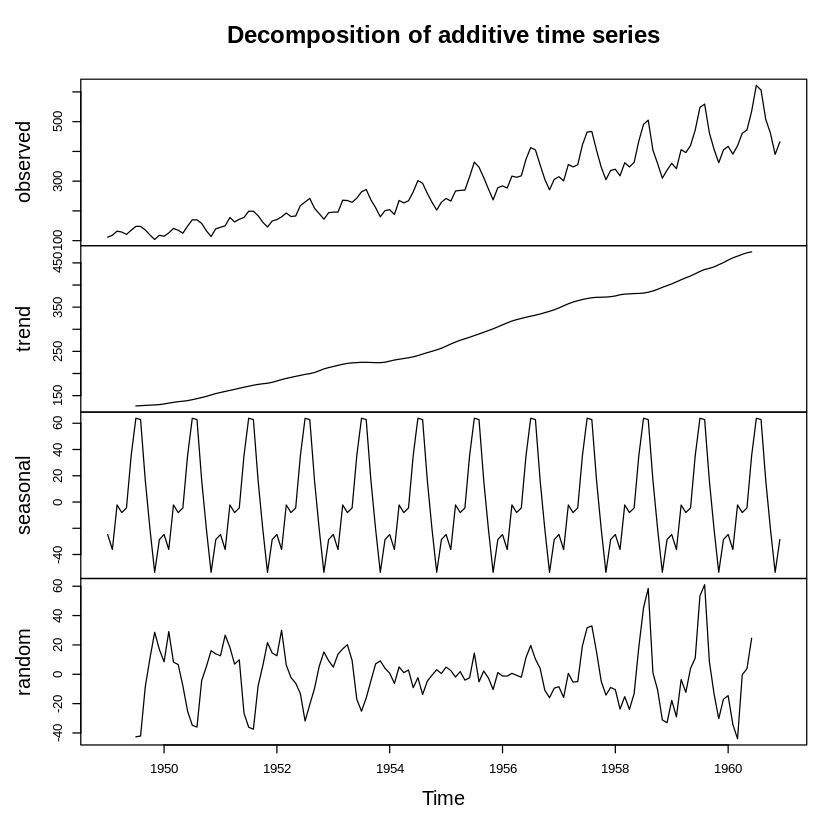

In [ ]:
plot(decompose(ts_data))

### 3. Check for Stationarity

In [ ]:
# Stationarity Check
cat("\nADF Test for Stationarity:\n")
adf_result <- adf.test(ts_data)
print(adf_result)


ADF Test for Stationarity:


Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -7.3186, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



So, does this mean our dataset which we thought is non-stationary because of increasing trend from decomposition actually wrong? Well, no. The ADF test can sometimes give wrong output if the dataset has high Seasonality, in which case it thinks its a stationary data which mighht not be the case.
Referring to the seasonality of our data from the decomposition graph we can see our data has a high seasonality.

So, even though ADF says "stationary," the decomposition clearly shows non-stationarity due to seasonal trend and increasing variance.

✔ CONCLUSION : The dataset is non-stattionary and the ADF test is misleading in some cases.

### 4. Justifying why to use ARIMA
---
Convenience:

ARIMA includes the "I" (Integration) component, which automates differencing.

auto.arima() handles differencing internally based on the stationarity of the data, saving manual effort.

Clarity:

Using ARIMA communicates clearly that you are starting from a non-stationary dataset.

It reflects the true nature of the data, and the model you're using is appropriate for it.

Real-world best practice:

Most real-world time series (like air traffic, stock prices, sales) are non-stationary.

ARIMA is the standard because it handles this naturally.

### 5.Autocorrelation plot(ACF/PACF) : using this to define the parameters of our ARIMA model (p,d,f)
---

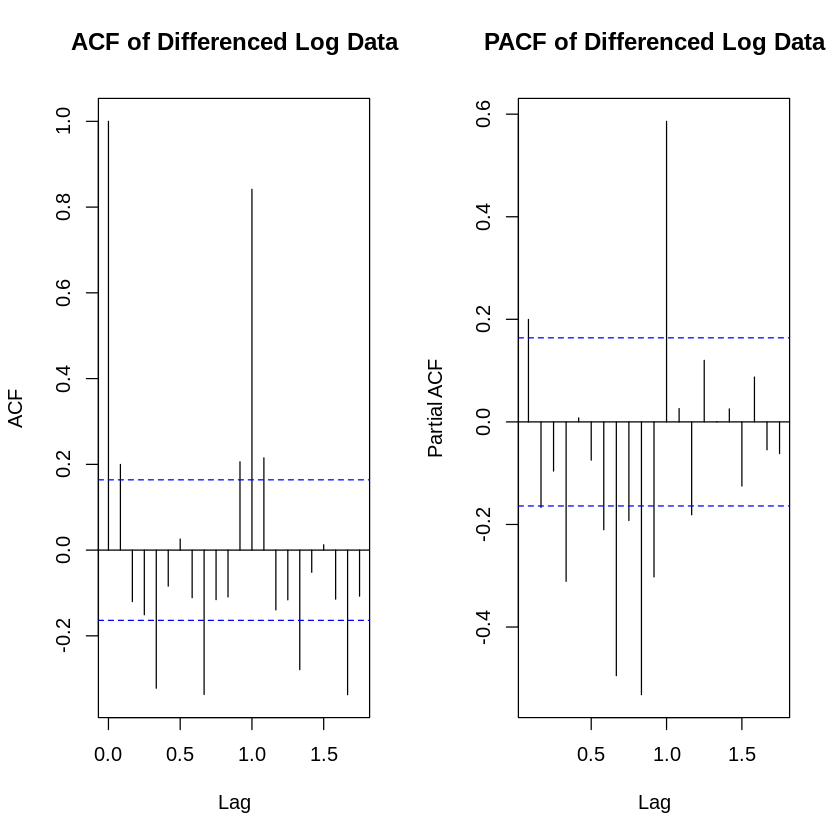

In [ ]:
# ACF and PACF Plots
par(mfrow = c(1, 2))
acf(diff(log(ts_data)), main = "ACF of Differenced Log Data")
pacf(diff(log(ts_data)), main = "PACF of Differenced Log Data")
par(mfrow = c(1, 1))

### 6. Fit ARIMA model
---


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,1)[12]
Q* = 20.34, df = 22, p-value = 0.5618

Model df: 2.   Total lags used: 24


ARIMA Model Summary:
Series: train 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.3424  -0.5405
s.e.   0.1009   0.0877

sigma^2 = 0.001432:  log likelihood = 197.51
AIC=-389.02   AICc=-388.78   BIC=-381

Training set error measures:
                        ME       RMSE        MAE           MPE      MAPE
Training set -0.0001250111 0.03539809 0.02640383 -0.0003836216 0.4867206
                  MASE        ACF1
Training set 0.2145046 0.005834845


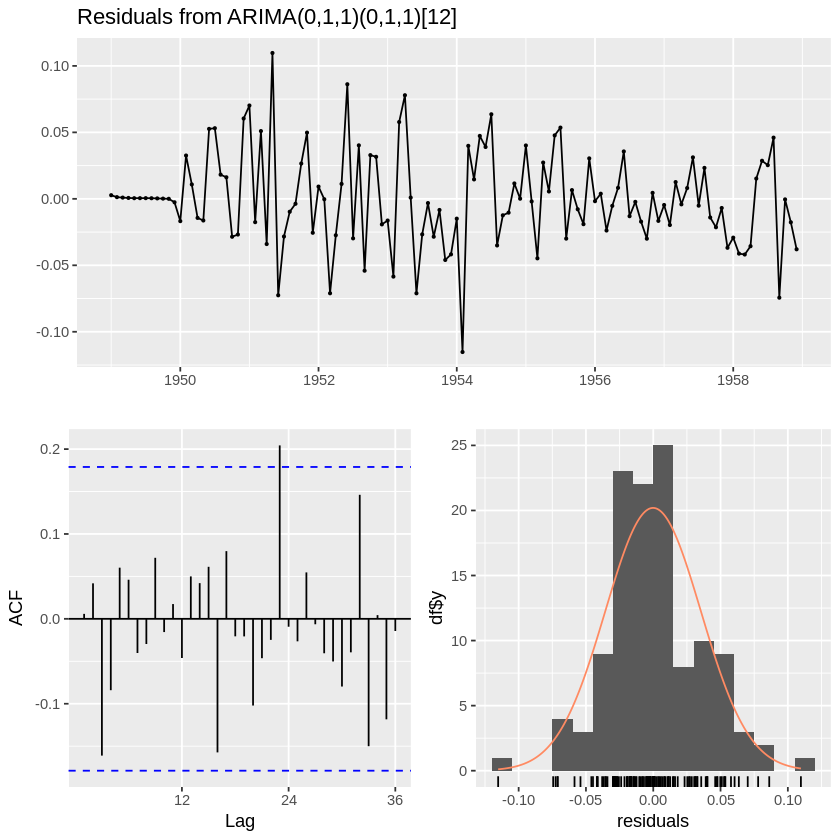

In [ ]:
# Train/Test Split
log_data <- log(ts_data)
train <- window(log_data, end = c(1958, 12))
test <- window(log_data, start = c(1959, 1))

# Fit ARIMA Model
fit <- auto.arima(train, seasonal = TRUE, stepwise = FALSE, approximation = FALSE)
checkresiduals(fit)

cat("\nARIMA Model Summary:\n")
print(summary(fit))

### 7. Forecasating future traffic of 24 months
---

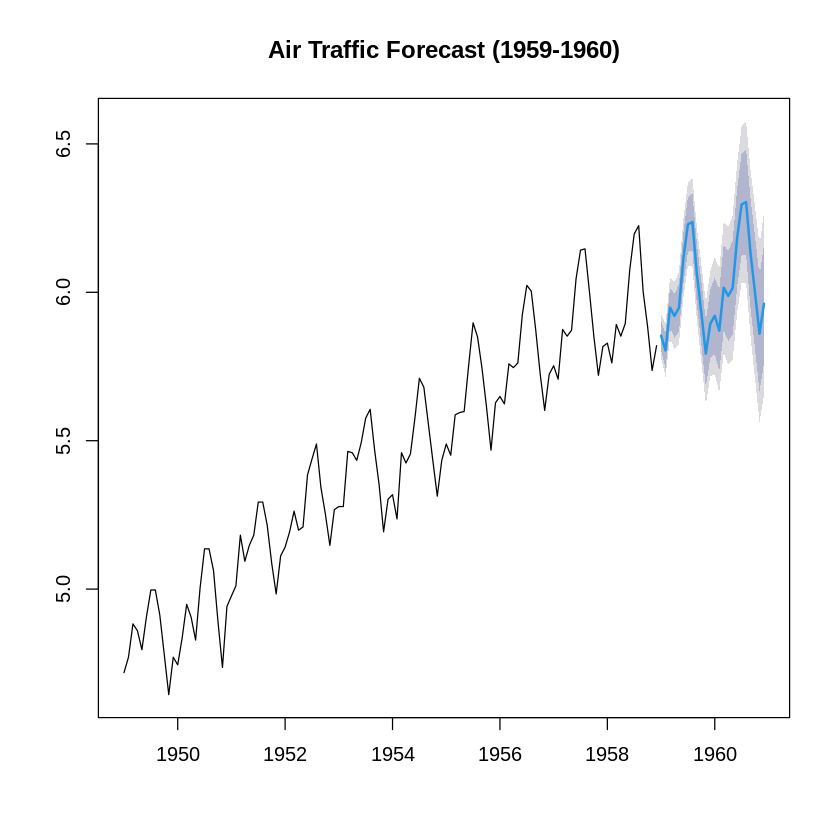

In [ ]:
# Forecasting
forecast_values <- forecast(fit, h = 24)
plot(forecast_values, main = "Air Traffic Forecast (1959-1960)")

### 8. Compare Actual v/s Predicted of 24 months(1959-1960)
---

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


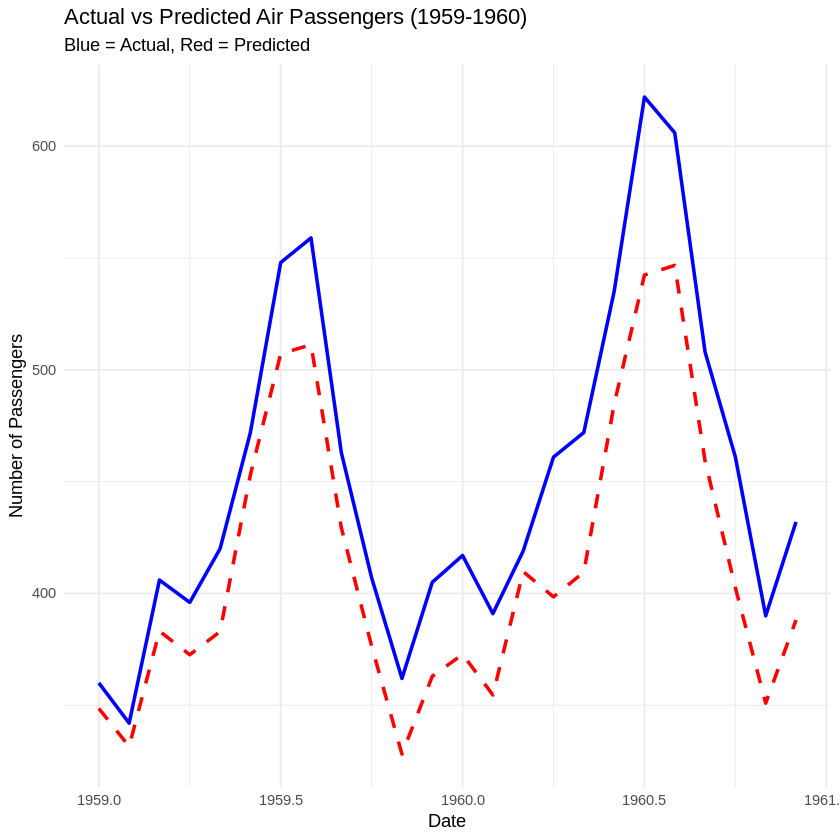

In [ ]:
# Compare Actual vs Predicted
yhat <- exp(forecast_values$mean)
ytrue <- exp(test)
comparison_df <- data.frame(
  Month = time(ytrue),
  Actual = as.numeric(ytrue),
  Predicted = as.numeric(yhat)
)

print(
ggplot(comparison_df, aes(x = Month)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", size = 1) +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red")) +
  labs(title = "Actual vs Predicted Air Passengers (1959-1960)",
       x = "Month", y = "Number of Passengers",
       color = "Legend") +
  theme_minimal()
)


In [ ]:
# Accuracy
cat("\nModel Accuracy:\n")
print(accuracy(yhat, ytrue))


Model Accuracy:
               ME     RMSE      MAE      MPE     MAPE      ACF1 Theil's U
Test set 39.44726 43.18367 39.44726 8.516316 8.516316 0.4635997 0.8430396
